In [34]:
import geopandas as gpd 
import xarray as xr
import pandas as pd
import os
import numpy as np
import cfgrib
from cfgrib import cfmessage
from pathlib import Path
import eccodes
import matplotlib.pyplot as plt
import rioxarray


In [2]:
s5p_path = "../Data/raw/s5p/SO2_NO2_O3_Diario_Comunas_Region_de_Los_Rios.csv"
s5p = pd.read_csv(s5p_path)
s5p.head(5)

,system:index,Comuna,NO2_column_number_density,O3_column_number_density,Provincia,Region,SO2_column_number_density,cir_sena,cod_comuna,codregion,date,dis_elec,objectid,shape_leng,st_area_sh,st_length_,.geo
0,0_0000000000000000001e,La Unión,0.000072,0.133772,Ranco,Región de Los Ríos,0.000169,12,14201,14,2024-01-01,24,140,364280.015951,3.656689e+09,474203.726792,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.7..."
1,0_0000000000000000001f,Los Lagos,0.000072,0.133527,Valdivia,Región de Los Ríos,0.000547,12,14104,14,2024-01-01,24,143,316586.233799,3.042426e+09,412407.032880,"{""type"":""Polygon"",""coordinates"":[[[-72.9818706..."
2,0_00000000000000000020,Máfil,0.000070,0.134704,Valdivia,Región de Los Ríos,0.000409,12,14105,14,2024-01-01,24,144,181074.022363,9.787385e+08,235205.534329,"{""type"":""Polygon"",""coordinates"":[[[-73.0993812..."
3,0_00000000000000000021,Paillaco,0.000075,0.133430,Ranco,Región de Los Ríos,0.000024,12,14107,14,2024-01-01,24,146,209143.467414,1.540642e+09,273186.467923,"{""type"":""Polygon"",""coordinates"":[[[-73.1733890..."
4,0_00000000000000000085,Lanco,0.000076,0.135013,Valdivia,Región de Los Ríos,0.000908,12,14103,14,2024-01-01,24,142,152128.428573,8.938992e+08,196801.580866,"{""type"":""Polygon"",""coordinates"":[[[-72.8485345..."


In [ ]:
file_path = "../Data/raw/era5/data.grib"
short_names = set()

with open(file_path, "rb") as f:
    while True:
        try:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            short_name = eccodes.codes_get(gid, "shortName")
            short_names.add(short_name)
            eccodes.codes_release(gid)
        except Exception as e:
            break

print("Variables encontradas:", short_names)

Variables encontradas: {'2d', '2t', 'tp', '10v', '10u'}


In [ ]:
era5_path = "../Data/raw/era5/data.grib"
output_dir = Path("../Data/processed/")
output_dir.mkdir(parents=True, exist_ok=True)

variables = ["2t", "2d", "tp", "10u", "10v"]

for var in variables:
    try:
        print(f"Abriendo {var}...")
        ds = xr.open_dataset(
            era5_path,
            engine="cfgrib",
            backend_kwargs={'filter_by_keys': {'shortName': var}}
        )
        ds.to_netcdf(output_dir / f"{var}.nc")
        print(f"✅ Guardado en {output_dir / f'{var}.nc'}")
    except Exception as e:
        print(f"⚠️ Error con {var}: {e}")

Abriendo 2t...
✅ Guardado en ..\Data\processed\2t.nc
Abriendo 2d...
✅ Guardado en ..\Data\processed\2d.nc
Abriendo tp...
✅ Guardado en ..\Data\processed\tp.nc
Abriendo 10u...
✅ Guardado en ..\Data\processed\10u.nc
Abriendo 10v...
✅ Guardado en ..\Data\processed\10v.nc


In [24]:
PROCESSED = "../Data/processed"

# util: abrir la 1ª variable del .nc como DataArray
def open_first_var(path_nc):
    ds = xr.open_dataset(path_nc)
    var = list(ds.data_vars)[0]
    return ds[var]

t2m_k = open_first_var(f"{PROCESSED}/2t.nc")
d2m_k = open_first_var(f"{PROCESSED}/2d.nc")

T  = t2m_k - 273.15
Td = d2m_k - 273.15

rh = 100.0 * np.exp((17.625*Td/(243.04 + Td)) - (17.625*T/(243.04 + T)))
rh = rh.clip(min=0, max=100).rename("rh_pct")

try:
    rh_daily = rh.resample(time="1D").mean().rename("rh_pct")
except Exception:
    rh_daily = rh

rh.to_netcdf(f"{PROCESSED}/rh_pct_hourly.nc")           # si tu serie es horaria
rh_daily.to_netcdf(f"{PROCESSED}/rh_pct_daily.nc")

rh_daily.to_dataframe().reset_index().to_parquet(f"{PROCESSED}/rh_pct_daily.parquet", index=False)

print("✅ RH diaria guardada en:", f"{PROCESSED}/rh_pct_daily.nc")


✅ RH diaria guardada en: ../Data/processed/rh_pct_daily.nc


In [29]:
nc_path = "../Data/processed/rh_pct_daily.nc"

# 1) Abrir NetCDF y tomar la variable (DataArray)
ds = xr.open_dataset(nc_path)
var_name = list(ds.data_vars)[0]
rh = ds[var_name]  # DataArray con dims (time, lat, lon) o (time) según tu resample

# 2) A DataFrame (quedará 'time' y 'rh_pct')
df = rh.to_dataframe().reset_index()

print("Columnas:", df.columns.tolist())
print("Filas:", len(df))
print("Primeras 5:")
display(df.head())
print("Últimas 5:")
display(df.tail())

# 3) Rango temporal y frecuencia
tmin, tmax = df["time"].min(), df["time"].max()
print("Rango temporal:", tmin, "→", tmax)

# Frecuencia (intento automático)
try:
    freq = pd.infer_freq(df["time"].sort_values())
    print("Frecuencia inferida:", freq)
except Exception:
    pass

# 4) Chequeo de días faltantes (si es diario)
ts = df["time"].sort_values()
exp = pd.date_range(ts.min().normalize(), ts.max().normalize(), freq="D")
missing = exp.difference(pd.to_datetime(ts).dt.normalize())
print("Días esperados:", len(exp), " | Días presentes:", ts.nunique(), " | Faltantes:", len(missing))
if len(missing) > 0:
    print("Ejemplos de días faltantes:", missing[:10])

Columnas: ['time', 'latitude', 'longitude', 'number', 'step', 'surface', 'rh_pct']
Filas: 29430
Primeras 5:


,time,latitude,longitude,number,step,surface,rh_pct
0,2024-01-01,-39.5,-73.90,0,0 days,0.0,91.140251
1,2024-01-01,-39.5,-73.65,0,0 days,0.0,91.772720
2,2024-01-01,-39.5,-73.40,0,0 days,0.0,91.685768
3,2024-01-01,-39.5,-73.15,0,0 days,0.0,93.392044
4,2024-01-01,-39.5,-72.90,0,0 days,0.0,94.087059


Últimas 5:


,time,latitude,longitude,number,step,surface,rh_pct
29425,2025-10-15,-40.5,-72.90,0,0 days,0.0,81.329422
29426,2025-10-15,-40.5,-72.65,0,0 days,0.0,85.126350
29427,2025-10-15,-40.5,-72.40,0,0 days,0.0,85.832916
29428,2025-10-15,-40.5,-72.15,0,0 days,0.0,88.328629
29429,2025-10-15,-40.5,-71.90,0,0 days,0.0,91.529915


Rango temporal: 2024-01-01 00:00:00 → 2025-10-15 00:00:00
Frecuencia inferida: None
Días esperados: 654  | Días presentes: 654  | Faltantes: 0


In [30]:
pq_path = "../Data/processed/rh_pct_daily.parquet"
try:
    df_pq = pd.read_parquet(pq_path)  # requiere pyarrow o fastparquet
    print("Parquet filas:", len(df_pq), " | columnas:", df_pq.columns.tolist())
    display(df_pq.head())
except Exception as e:
    print("No se pudo leer el Parquet:", e)

Parquet filas: 29430  | columnas: ['time', 'latitude', 'longitude', 'number', 'step', 'surface', 'rh_pct']


,time,latitude,longitude,number,step,surface,rh_pct
0,2024-01-01,-39.5,-73.90,0,0 days,0.0,91.140251
1,2024-01-01,-39.5,-73.65,0,0 days,0.0,91.772720
2,2024-01-01,-39.5,-73.40,0,0 days,0.0,91.685768
3,2024-01-01,-39.5,-73.15,0,0 days,0.0,93.392044
4,2024-01-01,-39.5,-72.90,0,0 days,0.0,94.087059


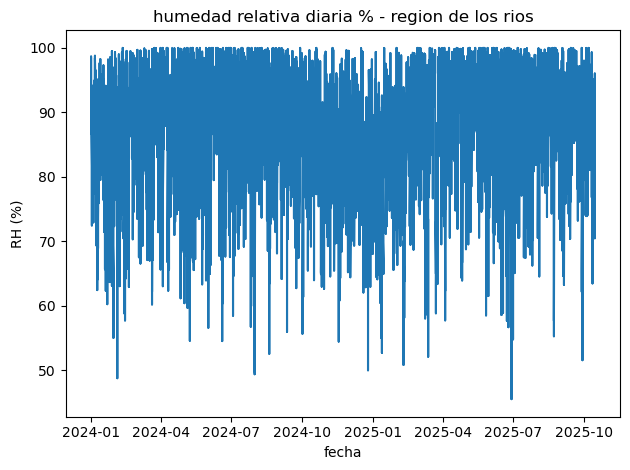

In [33]:
df_plot = df.sort_values("time")
plt.figure()
plt.plot(df_plot["time"], df_plot[var_name])
plt.title("humedad relativa diaria % - region de los rios")
plt.xlabel("fecha"); plt.ylabel("RH (%)")
plt.tight_layout()
plt.show()

In [38]:
rh = xr.open_dataset("../Data/processed/rh_pct_daily.nc") ["rh_pct"]
rh = rh.rio.write_crs("EPSG:4326", inplace=True)
rh_utm = rh.rio.reproject("EPSG:32719")
rh_utm_1km = rh_utm.rio.reproject(
    "EPSG:32719", resolution=1000
)
rh_utm_1km.to_netcdf("../Data/processed/rh_pct_utm1km.nc")
print("✅ Reproyección a EPSG:32719 completa.")

✅ Reproyección a EPSG:32719 completa.
